# AWS bird detection

We thank F21 semesters student's for the base code

Authors: Wenbin Li

This jupyter notebook is meant to run on AWS sagemaker studio. All the file location should be on S3 bucket or any other bucket service.

## Installation and setup for Colab

Run the next cells to setup Colab with the necessary requirements. We clone the Github repo with the developed code, and install dependencies, namely Detectron2. 

In [1]:
!pip install scikit-image

In [2]:
# Import useful libraries
import os, sys, shutil, glob
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2
from skimage import io  
from datetime import datetime
from distutils.dir_util import copy_tree
import boto3
import seaborn as sns
from tqdm.autonotebook import tqdm
from PIL import Image, ImageDraw
import csv
import random
import boto3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [ ]:
! ls

In [3]:
# This cell only excecutes if you're running on Colab. 
# if 'google.colab' in sys.modules:
#   from google.colab import drive 
#   drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone Audubon bird detection Github repo 
#   !git clone https://github.com/RiceD2KLab/Audubon_F21.git 

  # Install dependencies 
  !pip install -qq pyyaml==5.1
  # This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
  !pip install -qq torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

  # Install detectron2 that matches the above pytorch version
  # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
  !pip install -qq detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
  # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  !pip install -qq wandb

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger


## Data exploration & wrangling

The following cells contain the data exploration and wrangling modules of the data science pipeline. 


### Load dataset from Google Drive 

The following cell unzips a folder stored on Google Drive ontop the Colab machine. You can modify this cell to load your drone images onto the Colab instance! 


In [ ]:
# s3 = boto3.resource('s3')
# for bucket in s3.buckets.all():
#     print(bucket.name)
    
# my_bucket = 'sagemaker-studio-zd1j05seaof'
# my_file = '1017_1/DJI_20210520122305_0032.JPG'
# s3client = boto3.client('s3')
# response = s3client.get_object(Bucket=my_bucket, Key=my_file)
# body = response['Body']

In [ ]:
# from PIL import Image
# from io import BytesIO

# im = Image.open(body)
# image = np.array(im)


In [ ]:
# plt.figure(figsize = (20,10))
# plt.imshow(image[500:1300, 500:2000])

In [5]:
# this is to load up the file path for the annotation
my_bucket = 'sagemaker-studio-zd1j05seaof'
conn = boto3.client('s3')
annot_path = 'annotation_1017/'
annot = conn.list_objects(Bucket=my_bucket, Prefix=annot_path)['Contents']
# for f in annot:
# #     print(f['Key']) # print what files are in this specific folder

In [6]:
annot[1]['Key']

'annotation_1017/DJI_20210520122305_0032.bbx'

### Data exploration on AWS

The following cells generate some metrics and plots to help understand the loaded dataset. 

In [7]:
s3client = boto3.client('s3')
target_data = []
for f in annot:
    response = s3client.get_object(Bucket=my_bucket, Key=f['Key'])
    body = response['Body']
    target_data.append(pd.read_csv(body, header=0, 
                       names = ["class_id", "class_name", "x", "y", "width", "height"] ))
target_data = pd.concat(target_data, axis=0, ignore_index=True)


In [8]:
# target_data
print('\n Bird Species Distribution')
print(target_data["class_name"].value_counts())
print('\n')


 Bird Species Distribution
Laughing Gull Adult       772
Mixed Tern Adult          286
Mixed Tern Flying          19
Laughing Gull Flying       17
Other Bird                 16
Trash/Debris               13
Brown Pelican Adult         5
Brown Pelican Juvenile      1
Name: class_name, dtype: int64




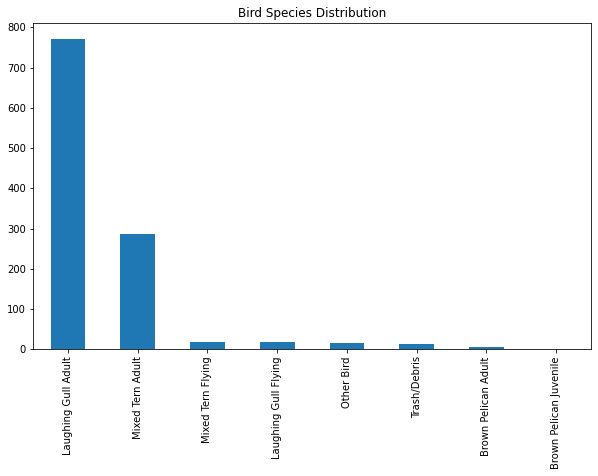

In [9]:
ax = target_data["class_name"].value_counts().plot.bar(figsize=(10,6))  
ax.set_title('Bird Species Distribution')
plt.show()

In [11]:
# key_exist(my_bucket, 'annotation_1017/')


NameError: name 'annotation_lst' is not defined

In [10]:
# from PIL import Image 
from PIL import Image
from utils import plotting
from utils.cropping import csv_to_dict_AWS

annot_dict = csv_to_dict_AWS(bucket_name= my_bucket,key = 'annotation_1017/DJI_20210520121104_0601.bbx', im_fold = '1017_2/')
annotation_lst = [list(x.values()) for x in annot_dict['bbox']]

imre = s3client.get_object(Bucket = my_bucket, Key= '1017_2/DJI_20210520121104_0601.JPG' )
im = Image.open(imre['Body'])

print("Raw image with bounding boxes:")
plotting.plot_img_bbx(im, annotation_lst) 

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [ ]:
# [x['Key'] for x in s3client.list_objects_v2(Bucket = my_bucket, Prefix = '1017_2/')['Contents']]

### Tiling 

In order to prepare the dataset to be used for training in our deep learning models, we must tile the large 8192 × 5460 raw drone images into smaller sizes. The size of generated images can be specified by setting parameters and is default to be 640 × 640.

The following cells tiles the original dataset images and corresponding annotations in annotation files. 

In [12]:
# check if the key/directory exist in the S3 bucket
# a key can be the folder location or the file name
def key_exist(my_bucket, my_key, s3 = 's3'):
    # sujective to change for the bucket placement
    s3_client = boto3.client(s3)
    response = s3_client.list_objects_v2(Bucket=my_bucket, Prefix=my_key,MaxKeys=1)
    
    return 'Contents' in response

In [ ]:
# s3client.put_object(Bucket = my_bucket, Key = 'Test123/') #this is how to make a new director in S3 bucket
# im.save('./temp'+'/123.JPEG')
# s3client.upload_file(Filename='./temp/123.JPEG', Bucket = my_bucket, Key = 'Test123/123.JPEG') #this is how to upload a new file

In [16]:
def dict_to_csv_AWS(info_dict, output_path, empty):
    """
    Function to convert (cropped images') info_dicts to annoatation csv files
    INPUT:
     info_dict -- output from the csv_to_dict function, containing bbox, filename, img_size
     output_path -- folder path to store the converted csv files
    OUTPUT:
      an csv file(corresponding for 1 image) saved to a folder. The bndbox info in the format of (className,
      xmin, ymin, width, height)
    """
    new_bbx_buffer = []
    schema = ['class_id', 'desc', 'x', 'y', 'width', 'height']
    if not empty:
        for obj in info_dict['bbox']:
            className = obj['class']
            desc = obj['desc']
            xmin = obj['xmin']
            xmax = obj['xmax']
            ymin = obj['ymin']
            ymax = obj['ymax']
            # className, description, xmin, ymin, width, height
            new_bbx_buffer.append([className, desc, int(xmin), int(ymin), int(xmax) - int(xmin), int(ymax) - int(ymin)])
    # Name of the file to save
    save_file_name = os.path.join('./temp', info_dict["file_name"].replace('JPG', 'csv'))
    
    
    # write to files
    with open(save_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([g for g in schema])
        if not empty:
            writer.writerows(new_bbx_buffer)
            
    #Write it to the cloud
    s3client.upload_file(Filename = save_file_name, Bucket = my_bucket, Key = output_key +'/'+info_dict["file_name"].replace('JPG', 'csv'))

def tile_annot(left, right, top, bottom, info_dict, i, j, crop_height, crop_width, overlap, file_dict):
    """
    THIS FUNCTION calculate the new positions of bndbox in cropped img and append them to file_dict,
    which is an info dict for that cropped img.

    INPUTS:
    left, right, top, bottom -- params for the python crop img function, coordinates for tiles.
    origin is top left.
    info_dict -- the info_dict we get from the csv_to_dict function.
    overlap -- threshold for keeping a bbox.
    """
    # file_dict stores info of one subimage as a dictionary. keys indicate original file name and subimage position.
    file_dict[str(i) + '_' + str(j)] = {}
    file_dict[str(i) + '_' + str(j)]['bbox'] = []
    file_dict[str(i) + '_' + str(j)]['file_name'] = info_dict['file_name'][:-4] + '_' + str(i) + '_' + str(j) + '.JPG'
    file_dict[str(i) + '_' + str(j)]['img_size'] = (right - left, bottom - top, 3)

    valid = False
    for b in info_dict['bbox']:
        ymin = max(b['ymin'] - top, 0)
        ymax = min(b['ymax'] - top, crop_height)
        xmin = max(b['xmin'] - left, 0)
        xmax = min(b['xmax'] - left, crop_width)
        # if the bird is not in this patch, pass
        if xmin > crop_width or xmax < 0 or ymin > crop_height or ymax < 0:
            continue
        else:
            if (xmax - xmin) * (ymax - ymin) > overlap * (b['xmax'] - b['xmin']) * (b['ymax'] - b['ymin']) \
                    or b['xmin'] >= left and b['xmax'] <= right and b['ymin'] >= top and b['ymax'] <= bottom:
                valid = True
                # instance_dict is the info_dict for one patch
                instance_dict = {}
                # transform bbx coordinates
                instance_dict['class'] = b['class']
                instance_dict['desc'] = b['desc']
                instance_dict['xmin'] = max(b['xmin'] - left, 0)
                instance_dict['xmax'] = min(b['xmax'] - left, crop_width)
                instance_dict['ymin'] = max(b['ymin'] - top, 0)
                instance_dict['ymax'] = min(b['ymax'] - top, crop_height)

                file_dict[str(i) + '_' + str(j)]['bbox'].append(instance_dict)
    return valid


# this function generates all the cropped images and all corresponding label txt files for a single file
# file_dict stores cropped images info dict in one dictionary.
def crop_img_AWS(s3client, my_bucket, annot_key, img_key, output_key, crop_height, crop_width, class_map = {}, overlap=0.2, annot_file_ext='csv', file_dict={}):
    """
    This function crops one image and output corresponding labels.
    Currently, this function generates the cropped images AND the corresponding csv files to output_dir
    INPUT:
    crop_height, crop_weight -- desired patch size.
    overlap -- threshold for keeping bbx.
    annot_file_ext -- annotation file extension
    """
    print(img_key)
    print(annot_key)
    info_dict = csv_to_dict_AWS(bucket_name= my_bucket,key = annot_key, im_fold = img_key)
    
    img_height, img_width, img_depth = info_dict['img_size']
    
    image = s3client.get_object(Bucket = my_bucket, Key= img_key + annot_key.split('/')[-1].replace(annot_file_ext, 'JPG') )
    
    im = Image.open(image['Body'], 'r')
    
    file_name = annot_key.split('/')[-1].split('.')[0]
    
    # go through the image from top left corner
    for i in range(img_height // crop_height + 1):

        for j in range(img_width // crop_width + 1):

            if j < (img_width // crop_width) and i < (img_height // crop_height):
                left = j * crop_width
                right = (j + 1) * crop_width
                top = i * crop_height
                bottom = (i + 1) * crop_height

            elif j == img_width // crop_width and i < (img_height // crop_height):
                left = img_width - crop_width
                right = img_width
                top = i * crop_height
                bottom = (i + 1) * crop_height

            # if rectangles left on edges, take subimage of crop_height*crop_width by taking a part from within.
            elif i == img_height // crop_height and j < (img_width // crop_width):
                left = j * crop_width
                right = (j + 1) * crop_width
                top = img_height - crop_height
                bottom = img_height

            else:
                left = img_width - crop_width
                right = img_width
                top = img_height - crop_height
                bottom = img_height
                
            # even if no birds in cropped img, keep the cropped image
            
            if tile_annot(left, right, top, bottom, info_dict, i, j, crop_height, crop_width, overlap, file_dict):
                # print('Generating segmentation at position: ', left, top, right, bottom)
                
                c_img = im.crop((left, top, right, bottom))
                c_img_name = file_name + '_' + str(i) + '_' + str(j) +'.JPEG'
                
                # write all this is the temporary folder in the current working directory
                c_img.save('./temp'+'/'+c_img_name)
                
                #uploading it to the bucket storage
                s3client.upload_file(Filename = './temp'+'/'+c_img_name, Bucket = my_bucket, Key = output_key +'/'+c_img_name)
                
                

    # output the file_dict to a folder of csv files containing labels for each cropped file
    for b in file_dict:
        if file_dict[b]['bbox'] == []:
            empty = True
            continue
        else:
            empty = False
            dict_to_csv_AWS(file_dict[b], empty=empty, output_path=output_key)

    return file_dict


def crop_dataset_AWS(bucket, data_key, output_key, annot_key, annot_file_ext = 'csv', class_map = {}, crop_height=640, crop_width=640):
    """
    :param data_dir: image set directory
    :param output_dir: output directory
    :param annot_file_ext: annotation file extension
    :param crop_height: image height after tiling, default 640
    :param crop_width: image width after tiling, default 640
    """
    s3client = boto3.client('s3') # start grabbing or makign directory in S3 bucket
    
    
    if not key_exist(my_bucket = bucket, my_key = output_key): # this function works only for S3 bucket, will change if we need to modularize this
        print(f"Creating output directory at in S3 bucket called: {output_key}")
        s3client.put_object(Bucket = bucket, Key = output_key)
        
    # making temporary folder in the current directory
    if not os.path.exists('./temp'):
        print(f"Creating temp folder")
        os.makedirs('./temp')

                            

    # find all the files inside the annotated folders                            
    if annot_file_ext == 'csv':
        files = [x['Key'] for x in s3client.list_objects_v2(Bucket = my_bucket, Prefix = annot_key)['Contents']]
    if annot_file_ext == 'bbx':
        files = [x['Key'] for x in s3client.list_objects_v2(Bucket = my_bucket, Prefix = annot_key)['Contents']]
                            
                            
    # for each annotated file, crop the image and place it into the output directory
    for f in tqdm(files, desc='Cropping files'):
        crop_img_AWS(s3client = s3client, my_bucket = bucket, annot_key=f ,img_key = data_key, output_key = output_key, crop_height=crop_height, crop_width=crop_width, class_map=class_map,
                 annot_file_ext=annot_file_ext)
    
    shutil.rmtree('./temp')
    return None
#     


# def crop_dataset_AWS(bucket, data_key, output_key, annot_file_ext = 'csv', class_map = {}, crop_height=640, crop_width=640):
#     """
#     :param data_dir: image set directory
#     :param output_dir: output directory
#     :param annot_file_ext: annotation file extension
#     :param crop_height: image height after tiling, default 640
#     :param crop_width: image width after tiling, default 640
#     """
#     s3client = boto3.client('s3') # start grabbing or makign directory in S3 bucket
    
    
#     if not key_exist(my_bucket = bucket, my_key = output_key): # this function works only for S3 bucket, will change if we need to modularize this
#         print(f"Creating output directory at in S3 bucket called: {output_key}")
#         s3client.put_object(Bucket = bucket, Key = output_key)
#         s3client.put_object(Bucket = bucket, Key = output_key+'Intermediate/')
#     elif not key_exist(my_bucket = bucket, my_key = output_key +'Intermediate/'):
#         s3client.put_object(Bucket = bucket, Key = output_key+'Intermediate/')
        
#     # making temporary folder in the current directory
#     if not os.path.exists('./temp'):
#         print(f"Creating temp folder")
#         os.makedirs('./temp')
#         os.makedirs(os.path.join('./temp', 'Intermediate'))
#     elif not os.path.exists(os.path.join('./temp', 'Intermediate')):
#         os.makedirs(os.path.join('./temp', 'Intermediate'))

                            

#     # find all the files inside the annotated folders                            
#     if annot_file_ext == 'csv':
#         files = [data_key+Prex['Key'] for x in s3client.list_objects_v2(Bucket = my_bucket, Prefix = data_key)['Contents']]
#     if annot_file_ext == 'bbx':
#         files = [data_key+Prex['Key'] for x in s3client.list_objects_v2(Bucket = my_bucket, Prefix = data_key)['Contents']]
                            
                            
#     # for each annotated file, crop the image and place it into the output directory
#     for f in tqdm(files, desc='Cropping files'):
#         crop_img_AWS(s3client = s3client, my_buckey = bucket, annot_key=f,img_key = data_key, crop_height=crop_height, crop_width=crop_width, output_key=output_key, class_map=class_map,
#                  annot_file_ext=annot_file_ext)

#     shutil.rmtree(os.path.join(output_dir, 'Intermediate'))

In [17]:
# from Audubon_F21.utils.cropping import crop_dataset

# # data_dir is the path that contains both images and annotations (image: jpg; annotation: csv or bbx)
# data_dir = './data/raw' # data directory folder 
# # output dir is the path where you want to output new files. Please use the folder you defined above.
# output_dir = './data/tiled'

data_key = '1017_1/'
output_key = 'test_crop/'
annot_key = 'annotation_1017/'

crop_dataset_AWS(bucket = my_bucket, data_key = data_key, output_key=output_key
                 , annot_key = annot_key, annot_file_ext = 'bbx',crop_height=640, crop_width=640)

# crop_dataset(data_dir, output_dir, annot_file_ext = 'bbx', crop_height = 640, crop_width = 640)

Cropping files:   0%|          | 0/18 [00:00<?, ?it/s]

1017_1/
annotation_1017/DJI_20210520122304_0031.bbx
1017_1/
annotation_1017/DJI_20210520122305_0032.bbx
1017_1/
annotation_1017/DJI_20210520122307_0033.bbx
1017_1/
annotation_1017/DJI_20210520122309_0034.bbx
1017_1/
annotation_1017/DJI_20210520122418_0076.bbx
1017_1/
annotation_1017/DJI_20210520122420_0077.bbx
1017_1/
annotation_1017/DJI_20210520122422_0078.bbx
1017_1/
annotation_1017/DJI_20210520122423_0079.bbx
1017_1/
annotation_1017/DJI_20210520122425_0080.bbx
1017_1/
annotation_1017/DJI_20210520122427_0081.bbx
1017_1/
annotation_1017/DJI_20210520122503_0103.bbx
1017_1/
annotation_1017/DJI_20210520122504_0104.bbx
1017_1/
annotation_1017/DJI_20210520122506_0105.bbx
1017_1/
annotation_1017/DJI_20210520122508_0106.bbx
1017_1/
annotation_1017/DJI_20210520122509_0107.bbx
1017_1/
annotation_1017/DJI_20210520122511_0108.bbx
1017_1/
annotation_1017/DJI_20210520122513_0109.bbx
1017_1/
annotation_1017/DJI_20210520122515_0110.bbx


In [ ]:
def train_val_test_split_AWS(file_dir, output_dir, train_frac=0.8, val_frac=0.1):
    """
    :param file_dir: crop_dataset()'s output path:
    :param output_dir: an empty folder
    :param train_frac: fraction for training
    :param val_frac: fraction for validation, 1-train-val will be fraction for test
    """
    p = Path(output_dir)
    p1 = Path(os.path.join(output_dir, 'train'))
    p2 = Path(os.path.join(output_dir, 'val'))
    p3 = Path(os.path.join(output_dir, 'test'))

    if not p.is_dir():
        print('The output directory should be an empty folder')
    if not p1.is_dir():
        print('Please create an empty folder named "train" inside the output folder')
    if not p2.is_dir():
        print('Please create an empty folder named "val" inside the output folder')
    if not p3.is_dir():
        print('Please create an empty folder named "test" inside the output folder')

    img_list = [f for f in os.listdir(file_dir) if f[-4:] == 'JPEG']
    random.Random(4).shuffle(img_list)
    csv_list = [f.replace('JPEG', 'csv') for f in img_list]
    size = len(img_list)
    train_sz = int(size * train_frac)
    val_sz = int(size * val_frac)
    for idx in range(size):
        if idx < train_sz:
            shutil.move(os.path.join(file_dir, img_list[idx]), os.path.join(output_dir, 'train'))
            shutil.move(os.path.join(file_dir, csv_list[idx]), os.path.join(output_dir, 'train'))
        elif idx < train_sz + val_sz:
            shutil.move(os.path.join(file_dir, img_list[idx]), os.path.join(output_dir, 'val'))
            shutil.move(os.path.join(file_dir, csv_list[idx]), os.path.join(output_dir, 'val'))
        else:
            shutil.move(os.path.join(file_dir, img_list[idx]), os.path.join(output_dir, 'test'))
            shutil.move(os.path.join(file_dir, csv_list[idx]), os.path.join(output_dir, 'test'))

### Split dataset into training, validation, and test 


In [ ]:
 from Audubon_F21.utils.cropping import train_val_test_split

# create a new output folder for train, val, test dataset
# create three folders under the new output folder, with name 'train', 'val', 'test'
!mkdir -p /content/data/split
!mkdir -p /content/data/split/train
!mkdir -p /content/data/split/val
!mkdir -p /content/data/split/test

# specify the folder directory where you have the tiled images (output_dir of the crop_dataset() function)
file_dir = '/content/data/tiled'
# output_dir is the new output folder you created in the cell above
output_dir = '/content/data/split'
# train is a percentage, the fraction of files for training
train_frac = 0.8
# val is a percentage, the fraction of files for validation
val_frac = 0.1
# the fraction for test is default to be 1-train-val
train_val_test_split(file_dir, output_dir, train_frac=train_frac, val_frac=val_frac)

In [ ]:
# Distribution of bird species for train, val, and test sets
# data directory folders 
data_dir = 'data/split'
dirs = [d for d in os.listdir(data_dir)]

# Load CSV files 
for d in dirs: 
  target_data = []
  for f in glob.glob(os.path.join(data_dir,d,'*.csv')): 
    target_data.append(pd.read_csv(f, header=0, 
                              names = ["class_id", "class_name", "x", "y", "width", "height"]) )
  target_data = pd.concat(target_data, axis=0, ignore_index=True)

  # Visualize dataset 
  print(f'\n {d} - Bird Species Distribution')
  print(target_data["class_name"].value_counts())
  print('\n')

## Modeling 

The primary models used to detect birds within the drone images are convolutional neural network (CNN) based object detectors. To implement these models, we utilize [Detectron2](https://github.com/facebookresearch/detectron2), Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. 



### Setup dataloaders 

The following cell registers the training, validation, and testing datasets with Detectron2's dataset catalogs. Note that we register both a version that utilizes both a singular "bird-only" label and the bird species labels. 


In [ ]:
from Audubon_F21.utils.dataloader import register_datasets

data_dir = './data/split'
img_ext='.JPEG'
dirs = [os.path.join(data_dir,d) for d in os.listdir(data_dir)]

# Bird species used by object detector. Species contained in dataset that are 
# not contained in this list will be categorized as an "Unknown Bird"
BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]

# Bounding box colors for bird species (used when plotting images)
BIRD_SPECIES_COLORS = [(255,0,0), (255,153,51), (0, 255, 0), 
                       (0,0,255), (255, 51, 255)]

register_datasets(dirs,img_ext,BIRD_SPECIES,bird_species_colors=BIRD_SPECIES_COLORS)

### Training 

The following cells train a RetinaNet and Faster R-CNN model with a ResNet-50 FPN backbone. The model weights are initialized from a model pretrained on the MS COCO dataset. The training loop is based on Detectron2's Default Trainer.  Hyperparameters can be tweaked! 

#### Bird-only model

The bird-only model simplies localizes all birds and does not distiguish bird species. We utilize RetinaNet for faster performance rather than accuracy. 

In [ ]:
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2 import model_zoo
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "retinanet_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_only_train",)
cfg.DATASETS.TEST = ("birds_only_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 1e-3 # pick a good LR
cfg.SOLVER.GAMMA = 0.1 # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

#### Bird species 

The bird species model both localizes and classifies bird species. We registered the species to be classifed in the above dataloader (see BIRD_SPECIES list). We utilize Faster R-CNN for better performance. 

In [ ]:
from detectron2.utils.logger import setup_logger
from detectron2.config import get_cfg
from detectron2 import model_zoo
from Audubon_F21.utils.trainer import Trainer

# setup training logger 
setup_logger()

model_name = "faster_rcnn_R_50_FPN_1x"

# Create detectron2 config 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{model_name}.yaml"))
# Get pretrained model from MS COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{model_name}.yaml")

# add datasets used for training and validation 
cfg.DATASETS.TRAIN = ("birds_species_train",)
cfg.DATASETS.TEST = ("birds_species_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 1e-3 # pick a good LR
cfg.SOLVER.GAMMA = 0.1 # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES)
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = [500,]
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.OUTPUT_DIR = f"./output/multibirds_{model_name}"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train on bird species
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Evaluation

The following cell outputs various evaluation metrics, plots, and images. Please read more about the [COCO evaluation metrics](https://cocodataset.org/#detection-eval) to understand how the AP metrics are calculated. 

#### Bird-only

In [ ]:
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import plot_precision_recall

cfg.MODEL.WEIGHTS = "./output/bird_only_retinanet_R_50_FPN_1x/model_final.pth" # path to the model we just trained
predictor = DefaultPredictor(cfg)

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_only_val")
plot_precision_recall(val_precisions, val_max_recalls, ["Bird"])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_only_test")
plot_precision_recall(test_precisions, test_max_recalls, ["Bird"])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_only_{d}")
    print(f'\n {d} examples:')
    for k in random.sample(dataset_dicts, 2):
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]
        v = Visualizer(im[:, :, ::-1],
                        metadata=MetadataCatalog.get(f"birds_only_{d}"),
                        scale=0.5)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])

#### Bird species 

In [ ]:
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import plot_precision_recall

cfg.MODEL.WEIGHTS = "./output/multibirds_faster_rcnn_R_50_FPN_1x/model_final.pth" # path to the model we just trained
predictor = DefaultPredictor(cfg)

print('validation inference:')
val_precisions, val_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_val")
plot_precision_recall(val_precisions, val_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

print('test inference:')
test_precisions, test_max_recalls = get_precisions_recalls(cfg, predictor, "birds_species_test")
plot_precision_recall(test_precisions, test_max_recalls, BIRD_SPECIES + ["Unknown Bird"],
                      BIRD_SPECIES_COLORS + [(0, 0, 0)])

# Plot examples of detections on validation and testing tiled images 
for d in ["val", "test"]:
    dataset_dicts = DatasetCatalog.get(f"birds_species_{d}")
    print(f'\n {d} examples:')
    for k in random.sample(dataset_dicts, 2):
        im = cv2.imread(k["file_name"])
        outputs = predictor(im)
        outputs = outputs["instances"].to("cpu")
        outputs = outputs[outputs.scores > 0.5]
        v = Visualizer(im[:, :, ::-1],
                        metadata=MetadataCatalog.get(f"birds_species_{d}"),
                        scale=0.5,
                        instance_mode=ColorMode.SEGMENTATION)
        out = v.draw_instance_predictions(outputs)
        cv2.imshow(f'{d} prediction {i}',out.get_image()[:, :, ::-1])

## Running trained model on dataset

The following cells run a pretrained model on a dataset containing only raw images. It generates an output csv file containing the predicted bounding boxes after non-maximal suppression. 


### Tiling

The tiling step in the detection pipeline is done using a sliding window. The sub-images are deliberately generated to have a significant proportion of overlapping with adjacent sub-images. The level of overlapping can be specified by setting a parameter. The reason why we want to have the overlapping is because we can ensure that there is at least one complete version of each bird in one of the sub-images. We then try to eliminate overlapping predicted bounding boxes for the same bird by using non-maximum suppression.



In [ ]:
from Audubon_F21.utils.cropping import crop_dataset_img_only

# create folder to contain tiled images
!rm -rf './data/crop'
!mkdir -p './data/crop'

# perform tiling on images 
data_dir = './data/raw' # data directory folder 
output_dir = './data/crop'
img_ext = '.JPG'
CROP_WIDTH = 640 
CROP_HEIGHT = 640
SLIDING_SIZE = 400 
crop_dataset_img_only(data_dir, img_ext, output_dir, crop_height=CROP_HEIGHT, crop_width=CROP_WIDTH, sliding_size=SLIDING_SIZE)

### Run pipeline

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from Audubon_F21.utils.evaluation import evaluate_full_pipeline

# create list of tiled images to be run predictor on 
eval_file_lst = []
eval_file_lst = eval_file_lst + glob.glob('./data/crop/*.JPEG')

# Create detectron2 config and predictor 
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# download model weights
!gdown -q https://drive.google.com/uc?id=1-f_INg5D0yG7AJUkuSJUcIl6BSaf-smR 
# load model weights 
cfg.MODEL.WEIGHTS = "./model_final.pth"

BIRD_SPECIES = ["Brown Pelican", "Laughing Gull", "Mixed Tern",
                "Great Blue Heron","Great Egret/White Morph"]
SPECIES_MAP = {0: 'Brown Pelican', 1: 'Laughing Gull', 2: 'Mixed Tern', 3: 'Great Blue Heron',
               4: 'Great Egret/White Morph', 5: 'Other/Unknown'}

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(BIRD_SPECIES) 

# Create default predictor to run inference 
predictor = DefaultPredictor(cfg)
RAW_IMG_WIDTH = 8192
RAW_IMG_HEIGHT = 5460

# Run evaluation 
output_df = evaluate_full_pipeline(eval_file_lst, predictor, SPECIES_MAP, RAW_IMG_WIDTH, RAW_IMG_HEIGHT,
                           CROP_WIDTH, CROP_HEIGHT, SLIDING_SIZE)

### Download annotations as CSV file 


In [ ]:
from google.colab import files
output_df.to_csv('output.csv')
files.download('output.csv') 